In [ ]:
#!pip install mplsoccer

## Ejemplo de EDA - Analisis Táctico de Posición de Jugadores

En este caso se nos pide realizar un Análisis táctico del juego de ambos equipos y clasificar a los jugadores en base a su posición en el campo en una línea táctica del campo:

    + Linea Defensiva
    + Línea de Mediocampo
    + Línea de ataque
    
Se nos proporcionan datos de tracking de 14 jugadores, arbitro y balón cada 10 ms (los elementos que aparecen normalmente en el campo visual de la cámara)

    - Posición x,y en el campo
    - id del jugador capturado
    - id de la jugada por si se quiere hacer un análisis continuado de la jugada
    - periodo de juego
    - las medidas del campo son 105 x 52 y el punto (0,0) se encuentra en el centro del campo
    

In [3]:
import pandas as pd
from tqdm.notebook import tqdm
import warnings
import json
from mplsoccer.pitch import Pitch
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
warnings.filterwarnings('ignore')

In [4]:
file = 'data/structured_data.json'
file2 = 'data/match_data.json'

In [5]:
with open(file) as f:
        match_js = json.load(f)
    
with open(file2) as f2:
        match_data_js = json.load(f2)

In [6]:
match_js[0]

{'possession': {'trackable_object': None, 'group': None},
 'frame': 0,
 'data': [],
 'period': None,
 'time': None}

In [7]:
for i in range(len(match_js)):
    if match_js[i]['data']:
        print(i)
        print(match_js[i]['data'])
        break
    else:
        continue

205
[{'y': -0.673777901997, 'x': 11.5512222317, 'trackable_object': 1684, 'track_id': 6}, {'y': 16.819008836, 'x': -4.33622583416, 'trackable_object': 956, 'track_id': 16}, {'y': -17.2077689398, 'x': -15.7725977671, 'trackable_object': 11514, 'track_id': 1}, {'y': 0.3735507253, 'x': -2.43685734599, 'trackable_object': 5720, 'track_id': 4}, {'y': -5.39568702981, 'x': -17.6169120438, 'trackable_object': 3862, 'track_id': 10}, {'y': 8.94028336767, 'x': 1.70180448063, 'trackable_object': 6460, 'track_id': 5}, {'y': -4.00010500434, 'x': 9.87699957114, 'trackable_object': 10530, 'track_id': 15}, {'y': -15.9146808024, 'x': 0.108495511613, 'trackable_object': 6260, 'track_id': 2}, {'y': 7.19337908691, 'x': -6.97689032269, 'trackable_object': 12524, 'track_id': 14}, {'y': -9.13839491655, 'x': -5.5015924509, 'trackable_object': 9745, 'track_id': 7}]


In [8]:
match_data_js['players'][0]

{'injured': False,
 'own_goal': 0,
 'last_name': 'ter Stegen',
 'goal': 0,
 'red_card': 0,
 'number': 1,
 'id': 6679,
 'trackable_object': 6689,
 'team_id': 264,
 'birthday': '1992-04-30',
 'end_time': None,
 'first_name': 'Marc-Andre',
 'player_role': {'acronym': 'GK', 'id': 0, 'name': 'Goalkeeper'},
 'start_time': '00:00:00',
 'yellow_card': 0,
 'team_player_id': 3623}

Vamos a tratar de extraer la información que necesitamos de cada uno de los archivos para poder montar una tabla con la que nos sea más fácil trabajar

In [9]:
event = 0
events = []
for i in tqdm(range(len(match_js))):
    for j in range(len(match_js[i]['data'])):
        try:
            if match_js[i]['data'][j]['trackable_object']:
                event_id = event +1
                pos_x = match_js[i]['data'][j]['x']
                pos_y = match_js[i]['data'][j]['y']
                time = match_js[i]['time']
                period = match_js[i]['period']
                track_object = match_js[i]['data'][j]['trackable_object']
                track_id = match_js[i]['data'][j]['track_id']


                ev = {'event_id': event_id,
                      'pos_x': pos_x,
                      'pos_y':pos_y,
                      'time': time,
                      'period': period,
                      'track_object': track_object,
                      'track_id': track_id}
                events.append(ev)
            else:
                pass
        except:
            pass

  0%|          | 0/68400 [00:00<?, ?it/s]

In [18]:
df = pd.DataFrame(events)

df.head()

,event_id,pos_x,pos_y,time,period,track_object,track_id
0,1,11.551222,-0.673778,0:01.40,1.0,1684,6
1,1,-4.336226,16.819009,0:01.40,1.0,956,16
2,1,-15.772598,-17.207769,0:01.40,1.0,11514,1
3,1,-2.436857,0.373551,0:01.40,1.0,5720,4
4,1,-17.616912,-5.395687,0:01.40,1.0,3862,10


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 775254 entries, 0 to 775253
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   event_id      775254 non-null  int64  
 1   pos_x         775254 non-null  float64
 2   pos_y         775254 non-null  float64
 3   time          773918 non-null  object 
 4   period        773918 non-null  float64
 5   track_object  775254 non-null  int64  
 6   track_id      775254 non-null  int64  
dtypes: float64(3), int64(3), object(1)
memory usage: 41.4+ MB


Como nos interesa saber la posición del jugador durante todo el partido vamos a crear una nueva columna con su posición absoluta durante todo el encuentro, ya que a mitad del partido los equipos cambian de posición en el terreno de juego

In [20]:
p1 = df[df.period == 1]
p2 = df[df.period == 2]
p2['pos_x_abs'] = [-1 * i for i in p2.pos_x]
p2['pos_y_abs'] = [-1 * i for i in p2.pos_y]
p1['pos_x_abs'] = [1 * i for i in p1.pos_x]
p1['pos_y_abs'] = [1 * i for i in p1.pos_y]
all_p = pd.concat([p1,p2],0)

Ahora vamos a hacer lo mismo con la tabla de info de jugadores, genero una tabla y la filtro con las columnas que me interesan

In [21]:
players = pd.DataFrame(match_data_js['players'])
players.head()

,injured,own_goal,last_name,goal,red_card,number,id,trackable_object,team_id,birthday,end_time,first_name,player_role,start_time,yellow_card,team_player_id
0,False,0,ter Stegen,0,0,1,6679,6689,264,1992-04-30,None,Marc-Andre,"{'acronym': 'GK', 'id': 0, 'name': 'Goalkeeper'}",00:00:00,0,3623
1,False,0,Lenglet,0,0,15,11623,11712,264,1995-06-17,None,Clément,"{'acronym': 'LCB', 'id': 3, 'name': 'Left Cent...",00:00:00,1,7455
2,False,0,Alba,0,0,18,5326,5336,264,1989-03-21,None,Jordi,"{'acronym': 'LWB', 'id': 5, 'name': 'Left Wing...",00:00:00,0,2555
3,False,0,de Jong,0,0,21,12378,12524,264,1997-05-12,None,Frenkie,"{'acronym': 'LM', 'id': 9, 'name': 'Left Midfi...",00:00:00,0,21739
4,False,0,Roberto,0,0,20,9735,9745,264,1992-02-07,None,Sergi,"{'acronym': 'RM', 'id': 10, 'name': 'Right Mid...",00:00:00,0,379


In [22]:
players = pd.DataFrame(match_data_js['players'])[['id','trackable_object','first_name','last_name','team_id']]
pos = [match_data_js['players'][i]['player_role']['name'] for i in range(len(players))]
id_pos = [match_data_js['players'][i]['player_role']['id'] for i in range(len(players))]
home_away = ['Home' if match_data_js['home_team']['id'] == players['team_id'][i] else 'Away' for i in range(len(players))]
players['Position'] = pos
players['id_pos'] = id_pos
players['Home_Away'] = home_away

In [23]:
players.head()

,id,trackable_object,first_name,last_name,team_id,Position,id_pos,Home_Away
0,6679,6689,Marc-Andre,ter Stegen,264,Goalkeeper,0,Home
1,11623,11712,Clément,Lenglet,264,Left Center Back,3,Home
2,5326,5336,Jordi,Alba,264,Left Wing Back,5,Home
3,12378,12524,Frenkie,de Jong,264,Left Midfield,9,Home
4,9735,9745,Sergi,Roberto,264,Right Midfield,10,Home


Ahora unimos los dos dataframes para tener una tabla final con la que poder trabajar

In [24]:
final = all_p.merge(players, how='left', left_on='track_object', right_on='trackable_object' )

In [25]:
final.head()

,event_id,pos_x,pos_y,time,period,track_object,track_id,pos_x_abs,pos_y_abs,id,trackable_object,first_name,last_name,team_id,Position,id_pos,Home_Away
0,1,11.551222,-0.673778,0:01.40,1.0,1684,6,11.551222,-0.673778,1674.0,1684.0,,Casemiro,262.0,Center Midfield,8.0,Away
1,1,-4.336226,16.819009,0:01.40,1.0,956,16,-4.336226,16.819009,946.0,956.0,Antoine,Griezmann,264.0,Left Winger,12.0,Home
2,1,-15.772598,-17.207769,0:01.40,1.0,11514,1,-15.772598,-17.207769,11454.0,11514.0,Nelson,Semedo,264.0,Right Wing Back,6.0,Home
3,1,-2.436857,0.373551,0:01.40,1.0,5720,4,-2.436857,0.373551,5710.0,5720.0,Karim,Benzema,262.0,Center Forward,15.0,Away
4,1,-17.616912,-5.395687,0:01.40,1.0,3862,10,-17.616912,-5.395687,3852.0,3862.0,Gerard,Pique,264.0,Right Center Back,4.0,Home


Y divido la tabla entre el equipo de casa y el visitante para poder tratar con los datos de forma separada

In [26]:
final_home = final[final.Home_Away=='Home'].reset_index(drop=True)
final_home.reset_index(drop=True, inplace=True)
final_away = final[final.Home_Away=='Away']
final_away.reset_index(drop=True, inplace=True)

In [27]:
final_away.head()

,event_id,pos_x,pos_y,time,period,track_object,track_id,pos_x_abs,pos_y_abs,id,trackable_object,first_name,last_name,team_id,Position,id_pos,Home_Away
0,1,11.551222,-0.673778,0:01.40,1.0,1684,6,11.551222,-0.673778,1674.0,1684.0,,Casemiro,262.0,Center Midfield,8.0,Away
1,1,-2.436857,0.373551,0:01.40,1.0,5720,4,-2.436857,0.373551,5710.0,5720.0,Karim,Benzema,262.0,Center Forward,15.0,Away
2,1,9.877000,-4.000105,0:01.40,1.0,10530,15,9.877000,-4.000105,10520.0,10530.0,Toni,Kroos,262.0,Left Midfield,9.0,Away
3,1,45.366475,-0.530666,0:01.50,1.0,10271,17,45.366475,-0.530666,10261.0,10271.0,Thibaut,Courtois,262.0,Goalkeeper,0.0,Away
4,1,12.108070,-0.978041,0:01.50,1.0,1684,6,12.108070,-0.978041,1674.0,1684.0,,Casemiro,262.0,Center Midfield,8.0,Away


Con la intención de poder extrapolar nuestro análisis a otros partidos vamos a unificar el código en una función

## Análisis por Equipo

In [28]:
def generate_teams_match_data(file:str, file2:str)->(pd.DataFrame, pd.DataFrame):
    
    with open(file) as f:
        match_js = json.load(f)
    
    with open(file2) as f2:
        match_data_js = json.load(f2)
    
    event = 0
    events = []
    for i in tqdm(range(len(match_js))):
        for j in range(len(match_js[i]['data'])):
                try:
                    if match_js[i]['data'][j]['trackable_object']:
                        event_id = event +1
                        pos_x = match_js[i]['data'][j]['x']
                        pos_y = match_js[i]['data'][j]['y']
                        time = match_js[i]['time']
                        period = match_js[i]['period']
                        track_object = match_js[i]['data'][j]['trackable_object']
                        track_id = match_js[i]['data'][j]['track_id']


                        ev = {'event_id': event_id,
                              'pos_x': pos_x,
                              'pos_y':pos_y,
                              'time': time,
                              'period': period,
                              'track_object': track_object,
                              'track_id': track_id}
                        events.append(ev)
                    else:
                        pass
                except:
                    pass
    
    match = pd.DataFrame(events)
    p1 = match[match.period == 1]
    p2 = match[match.period == 2]
    p2['pos_x_abs'] = [-1 * i for i in p2.pos_x]
    p2['pos_y_abs'] = [-1 * i for i in p2.pos_y]
    p1['pos_x_abs'] = [1 * i for i in p1.pos_x]
    p1['pos_y_abs'] = [1 * i for i in p1.pos_y]
    all_p = pd.concat([p1,p2],0)
    
    players = pd.DataFrame(match_data_js['players'])[['id','trackable_object','first_name','last_name','team_id']]
    pos = [match_data_js['players'][i]['player_role']['name'] for i in range(len(players))]
    id_pos = [match_data_js['players'][i]['player_role']['id'] for i in range(len(players))]
    home_away = ['Home' if match_data_js['home_team']['id'] == players['team_id'][i] else 'Away' for i in range(len(players))]
    players['Position'] = pos
    players['id_pos'] = id_pos
    players['Home_Away'] = home_away
    
    final = all_p.merge(players, how='left', left_on='track_object', right_on='trackable_object' )
    
    final_home = final[final.Home_Away=='Home'].reset_index(drop=True)
    final_home.reset_index(drop=True, inplace=True)
    final_away = final[final.Home_Away=='Away']
    final_away.reset_index(drop=True, inplace=True)
    
    return final_home, final_away
    

In [29]:
f_h, f_a = generate_teams_match_data('data/structured_data.json','data/match_data.json' )

  0%|          | 0/68400 [00:00<?, ?it/s]

In [30]:
final_home.shape == f_h.shape

True

Con los datos ya generados podemos empezar nuestro análisis de los equipos

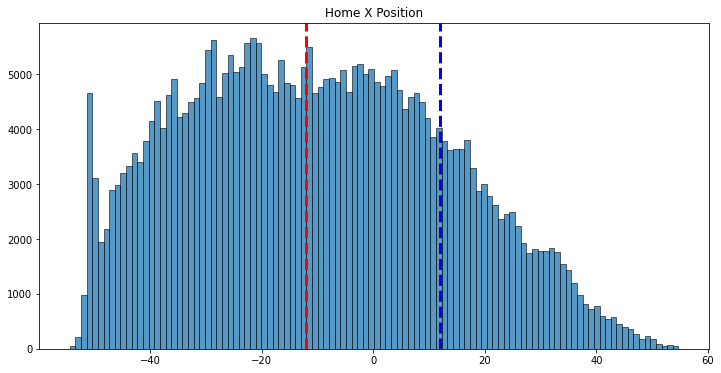

In [25]:
plt.figure(figsize=(12,6))
sns.histplot(f_h.pos_x_abs)
plt.title(f'{f_h.Home_Away[0]} X Position')
plt.axvline(-12,
            c='r',
            linewidth=3.,
            linestyle='--',
            label='Defending Line Limit')
plt.axvline(12,
            c='b',
            linewidth=3.,
            linestyle='--',
            label='Atacking Line Limit')
plt.ylabel(None)
plt.xlabel(None)
plt.show();

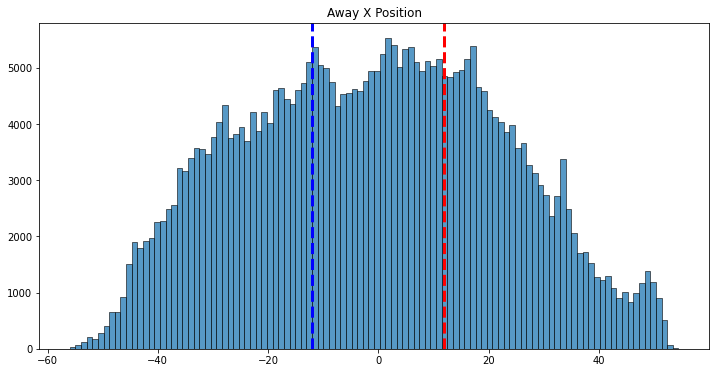

In [26]:
plt.figure(figsize=(12,6))
sns.histplot(f_a.pos_x_abs)
plt.title(f'{f_a.Home_Away[0]} X Position')
plt.axvline(12,
            c='r',
            linewidth=3.,
            linestyle='--',
            label='Defending Line Limit')
plt.axvline(-12,
            c='b',
            linewidth=3.,
            linestyle='--',
            label='Atacking Line Limit')
plt.ylabel(None)
plt.xlabel(None)
plt.show();

In [27]:
def plot_team_hist(df:pd.DataFrame)->None:
    
    '''
        This function reveices a dataframe and returns an histplot from the x values of all the players
        
        Parameters:
            df: Pandas dataframe with the team data
            
        Returns:
        
            Histogram of th value pos_x_abs
    
    '''
    
    plt.figure(figsize=(12,6))
    sns.histplot(f_h.pos_x_abs)
    plt.title(f'{df.Home_Away[0]} X Position')
    plt.ylabel(None)
    plt.xlabel(None)
    plt.show();

Como podemos observar a simple vista el equipo local estuvo más tiempo en zona defensiva y el equipo visitante estuvo más en la zona del medio campo y ataque, en este punto vamos ha utilizar una librería específica para poder pintar mapas de calor en el futbol

In [28]:
def plot_heatmap_team(df:pd.DataFrame, players:str)->None:
    
    print('Calculando posición de los jugadores en el terreno de juego ...\n')
    
    start_p = [n for n in df[df.period == 2].sort_values('id_pos').trackable_object.unique() if n in df[df.period == 1].trackable_object.unique()]
    subs = [n for n in df[df.period == 2].sort_values('id_pos').trackable_object.unique() if n not in df[df.period == 1].trackable_object.unique()]
    
    with plt.xkcd():
        matplotlib.rcParams['font.family'] = ['CENTAUR']
        pitch = Pitch(pitch_type='skillcorner', pitch_length= 105, pitch_width=68, pitch_color='limegreen', 
                  line_color='white', stripe=True, line_zorder=3)
        
        fig, ax = pitch.draw(figsize=(12,6))

        custcmap = matplotlib.colors.LinearSegmentedColormap.from_list('custom', ['limegreen','green','yellow','gold','orange','orangered','red'])
        kde = pitch.kdeplot(df.pos_x_abs, df.pos_y_abs, fill=True, ax=ax,
                       levels=100,shade=True, shade_lowest=True, cut=4, cmap=custcmap, zorder=1)
        
        print('Creando Mapa de calor ...\n')
        
        if players == 'start':
            def_line = 0
            mid_line = 0
            atk_line = 0
            for p in tqdm(start_p):
                
                name = df[df.trackable_object == p]['last_name'].values[0]
                x = round(df[df.trackable_object == p].pos_x_abs.median(),2)
                y = round(df[df.trackable_object == p].pos_y_abs.median(),2)
                
                if df.Home_Away.unique()[0] == 'Away':
                    
                    if 12 < x:
                        pl_clas = 'Defending Line'
                        def_line += 1
                    elif -12 < x < 12:
                        pl_clas = 'Midfield Line'
                        mid_line += 1
                    else:
                        pl_clas = 'Attacking Line'
                        atk_line += 1
                else:
                    
                    if 12 < x:
                        pl_clas = 'Attacking Line'
                        atk_line += 1
                    elif -12 < x < 12:
                        pl_clas = 'Midfield Line'
                        mid_line += 1
                    else:
                        pl_clas = 'Defending Line'
                        def_line += 1
                        
                print(f'{name} : {pl_clas} --> ({x},{y})')
                plt.annotate(f'+ {name}',(x,y), fontsize=20, zorder=4)
            #plt.annotate(f'Initial Squad - Tactic 1-{def_line-1}-{mid_line}-{atk_line}', (-25,35), color='black', fontsize= 20, zorder=4)
            plt.plot([-12,-12],[-35,35] ,color='r', zorder=3)
            plt.plot([12,12],[-35,35] ,color='r', zorder=3)
            plt.title(f'{df.Home_Away.unique()[0]} Team Initial Squad - Tactic 1-{def_line-1}-{mid_line}-{atk_line}', fontsize=25)
        
            print('\nGuardando imagen ...\n')
            plt.savefig(f'images/{df.Home_Away.unique()[0]}_Team.png')
        
        else:
            
            for p in tqdm(subs):
                name = df[df.trackable_object == p]['last_name'].values[0]
                x = round(df[df.trackable_object == p].pos_x_abs.median(),2)
                y = round(df[df.trackable_object == p].pos_y_abs.median(),2)
                
                if df.Home_Away.unique()[0] == 'Away':
                    
                    if 12 < x:
                        pl_clas = 'Defending Line'
                    elif -12 < x < 12:
                        pl_clas = 'Midfield Line'
                    else:
                        pl_clas = 'Attacking Line'
                        
                else:
                    
                    if 12 < x:
                        pl_clas = 'Attacking Line'
                    elif -12 < x < 12:
                        pl_clas = 'Midfield Line'
                    else:
                        pl_clas = 'Defending Line'
                        
                print(f'{name} : {pl_clas} --> (x:{x}, y:{y})')
                plt.annotate(f'+ {name}',(x,y), fontsize=20, zorder=4)
            #plt.annotate('Subtitutions', (-15,35), fontsize= 20)
            
            plt.plot([-12,-12],[-35,35] ,color='r', zorder=3)
            plt.plot([12,12],[-35,35] ,color='b', zorder=3)
            plt.title(f'{df.Home_Away.unique()[0]} Team Subtitutions', fontsize=25)
        
            print('\nGuardando imagen ...\n')
            plt.savefig(f'images/{df.Home_Away.unique()[0]}_Team_Subtitutions.png')
        plt.show();

Vamos a imprimir el mapa de calor del once inical del equipo local

#### Equipo Local

Calculando posición de los jugadores en el terreno de juego ...

Creando Mapa de calor ...



  0%|          | 0/11 [00:00<?, ?it/s]

ter Stegen : Defending Line --> (-50.17,0.38)
Lenglet : Defending Line --> (-26.92,7.59)
Pique : Defending Line --> (-25.93,-6.73)
Alba : Defending Line --> (-16.15,21.08)
Semedo : Defending Line --> (-16.83,-21.27)
Rakitic : Defending Line --> (-16.7,-0.71)
de Jong : Midfield Line --> (-11.12,6.44)
Roberto : Midfield Line --> (-10.3,-13.08)
Griezmann : Midfield Line --> (2.93,10.59)
Messi : Midfield Line --> (5.55,-10.24)
Suarez : Attacking Line --> (13.88,2.1)

Guardando imagen ...



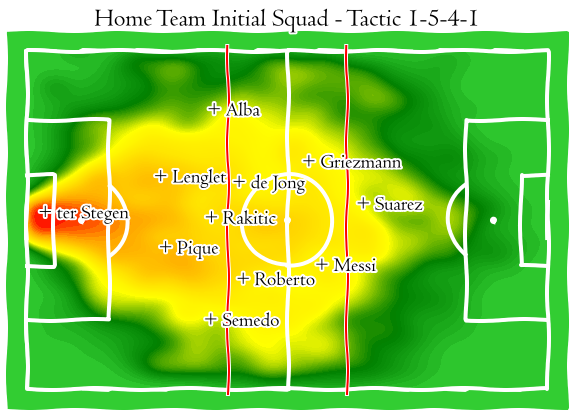

In [29]:
plot_heatmap_team(f_h, 'start')

Ahora el del visitante

#### Equipo Visitante

Calculando posición de los jugadores en el terreno de juego ...

Creando Mapa de calor ...



  0%|          | 0/11 [00:00<?, ?it/s]

Courtois : Defending Line --> (48.36,-0.37)
Ramos : Defending Line --> (14.9,-7.64)
Varane : Defending Line --> (17.52,4.12)
Mendy : Midfield Line --> (5.71,-20.72)
Carvajal : Midfield Line --> (6.25,17.02)
Casemiro : Midfield Line --> (6.03,0.81)
Kroos : Midfield Line --> (-4.6,-7.75)
Valverde : Midfield Line --> (-10.19,8.4)
Isco : Attacking Line --> (-15.2,-7.78)
Bale : Attacking Line --> (-12.75,15.9)
Benzema : Attacking Line --> (-20.82,-3.86)

Guardando imagen ...



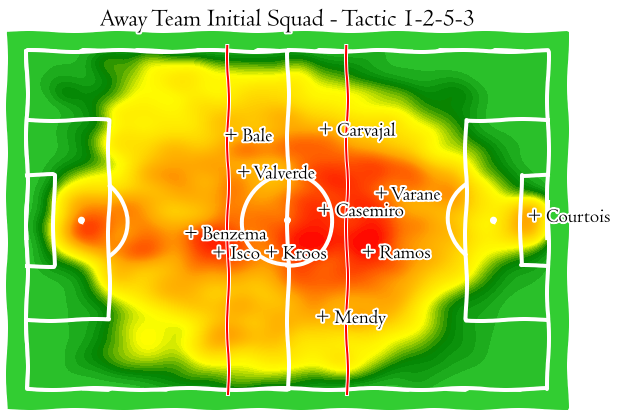

In [30]:
plot_heatmap_team(f_a, 'start')

## Análisis Jugador por Jugador

Con unos pequeños cambios podemos adaptar las funciones que creamos antes para analizar a un jugador específico

In [31]:
def generate_player_match_data(file:str, file2:str, id_player:str)->pd.DataFrame:    
    
    with open(file) as f:
            match_js = json.load(f)

    with open(file2) as f2:
            match_data_js = json.load(f2)

    event = 0
    events = []
    for i in tqdm(range(len(match_js))):
        for j in range(len(match_js[i]['data'])):
            try:
                if match_js[i]['data'][j]['trackable_object'] == id_player:
                    event_id = event +1
                    pos_x = match_js[i]['data'][j]['x']
                    pos_y = match_js[i]['data'][j]['y']
                    time = match_js[i]['time']
                    period = match_js[i]['period']
                    track_object = id_player


                    ev = {'event_id': event_id,
                          'pos_x': pos_x,
                          'pos_y':pos_y,
                          'time': time,
                          'period': period,
                          'track_object': track_object}
                    events.append(ev)
                else:
                    pass
            except:
                pass

    match = pd.DataFrame(events)
    p1 = match[match.period == 1]
    p2 = match[match.period == 2]
    p2['pos_x_abs'] = [-1 * i for i in p2.pos_x]
    p2['pos_y_abs'] = [-1 * i for i in p2.pos_y]
    p1['pos_x_abs'] = [1 * i for i in p1.pos_x]
    p1['pos_y_abs'] = [1 * i for i in p1.pos_y]
    all_p = pd.concat([p1,p2],0)

    players = pd.DataFrame(match_data_js['players'])[['id','trackable_object','first_name','last_name','team_id']]
    pos = [match_data_js['players'][i]['player_role']['name'] for i in range(len(players))]
    id_pos = [match_data_js['players'][i]['player_role']['id'] for i in range(len(players))]
    home_away = ['Home' if match_data_js['home_team']['id'] == players['team_id'][i] else 'Away' for i in range(len(players))]
    players['Position'] = pos
    players['id_pos'] = id_pos
    players['Home_Away'] = home_away

    final = all_p.merge(players, how='left', left_on='track_object', right_on='trackable_object' )
    
    return final

In [32]:
def plot_player_heatmap(df:pd.DataFrame)->None:
    
    name = df['last_name'][0]
    x = round(df.pos_x_abs.median(),2)
    y = round(df.pos_y_abs.median(),2)
                
    if df.Home_Away.unique()[0] == 'Away':
                    
        if 12 < x:
            pl_clas = 'Defending Line'
        elif -12 < x < 12:
            pl_clas = 'Midfield Line'   
        else:
            pl_clas = 'Attacking Line'
                
    else:    
        if 12 < x:
            pl_clas = 'Attacking Line'
        elif -12 < x < 12:
            pl_clas = 'Midfield Line' 
        else:
            pl_clas = 'Defending Line'
            
    print('Calculando posiciónes del jugadore en el terreno de juego ...\n')
    print('Creando Mapa de calor ...\n')
    
    with plt.xkcd():
        matplotlib.rcParams['font.family'] = ['CENTAUR']
        pitch = Pitch(pitch_type='skillcorner', pitch_length= 105, pitch_width=68, pitch_color='limegreen', 
                  line_color='white', stripe=False, line_zorder=3)
        fig, ax = pitch.draw(figsize=(12,6))
        
        custcmap = matplotlib.colors.LinearSegmentedColormap.from_list('custom', ['limegreen','green','yellow', 'gold','orange','orangered','red'])
        kde = pitch.kdeplot(df.pos_x_abs, df.pos_y_abs, fill=True, ax=ax,
                       levels=100, shade_lowest=True, cut=4, cmap=custcmap, zorder=1)
        
        plt.title(f'{df.first_name[0]} {name} - {pl_clas}', fontsize=25) 
        plt.annotate(f'+ {name}',(x,y), fontsize=20, zorder=4)
        plt.plot([-12,-12],[-35,35] ,color='r', zorder=3)
        plt.plot([12,12],[-35,35] ,color='r', zorder=3)
        
        
        print(f'{name} : {pl_clas} --> ({x},{y})')
        print('\nGuardando imagen ...\n')
        plt.savefig(f'images/{df.Home_Away[0]}/{name}_heatmap.png')
        
        plt.show();

Con estas dos funciones podemos generar mapas de calor de cada uno de los jugadores de ambos equipo para clasificarlos individualmente en la línea táctica

In [33]:
start_p_h = [n for n in f_h[f_h.period == 2].sort_values('id_pos').trackable_object.unique() if n in f_h[f_h.period == 1].trackable_object.unique()]
subs_h = [n for n in f_h[f_h.period == 2].sort_values('id_pos').trackable_object.unique() if n not in f_h[f_h.period == 1].trackable_object.unique()]
start_p_a = [n for n in f_a[f_a.period == 2].sort_values('id_pos').trackable_object.unique() if n in f_a[f_a.period == 1].trackable_object.unique()]
subs_a = [n for n in f_a[f_a.period == 2].sort_values('id_pos').trackable_object.unique() if n not in f_a[f_a.period == 1].trackable_object.unique()]

#### Análisis del equipo titular local

  0%|          | 0/68400 [00:00<?, ?it/s]

Calculando posiciónes del jugadore en el terreno de juego ...

Creando Mapa de calor ...

ter Stegen : Defending Line --> (-50.17,0.38)

Guardando imagen ...



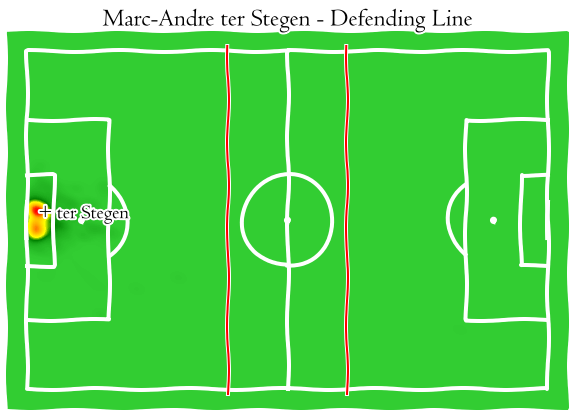

  0%|          | 0/68400 [00:00<?, ?it/s]

Calculando posiciónes del jugadore en el terreno de juego ...

Creando Mapa de calor ...

Lenglet : Defending Line --> (-26.92,7.59)

Guardando imagen ...



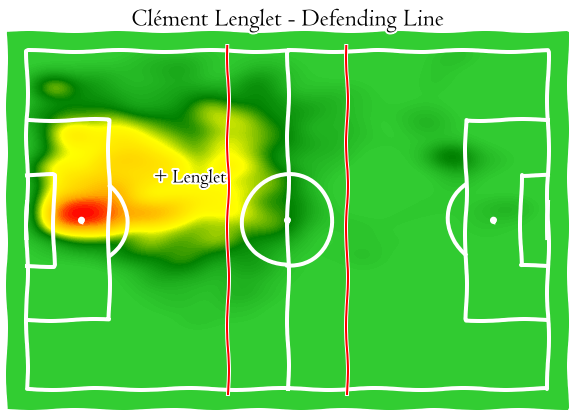

  0%|          | 0/68400 [00:00<?, ?it/s]

Calculando posiciónes del jugadore en el terreno de juego ...

Creando Mapa de calor ...

Pique : Defending Line --> (-25.93,-6.73)

Guardando imagen ...



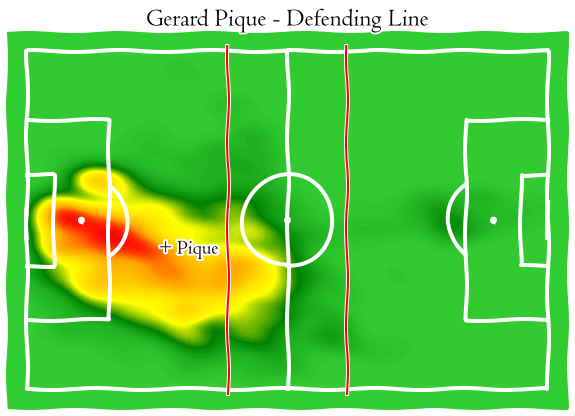

  0%|          | 0/68400 [00:00<?, ?it/s]

Calculando posiciónes del jugadore en el terreno de juego ...

Creando Mapa de calor ...

Alba : Defending Line --> (-16.15,21.08)

Guardando imagen ...



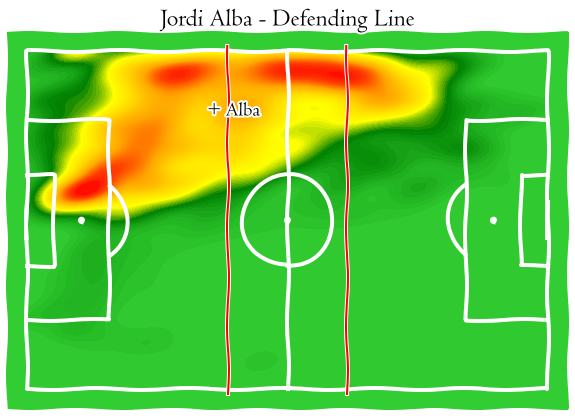

  0%|          | 0/68400 [00:00<?, ?it/s]

Calculando posiciónes del jugadore en el terreno de juego ...

Creando Mapa de calor ...

Semedo : Defending Line --> (-16.83,-21.27)

Guardando imagen ...



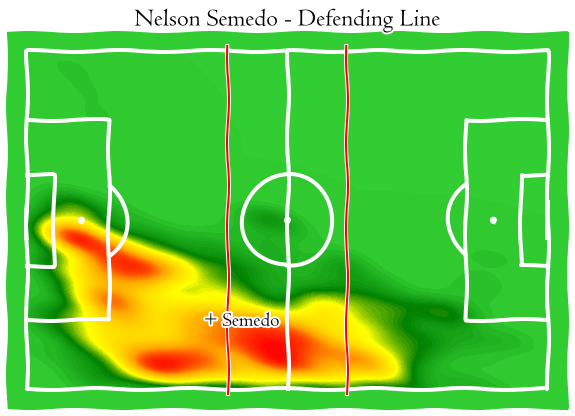

  0%|          | 0/68400 [00:00<?, ?it/s]

Calculando posiciónes del jugadore en el terreno de juego ...

Creando Mapa de calor ...

Rakitic : Defending Line --> (-16.7,-0.71)

Guardando imagen ...



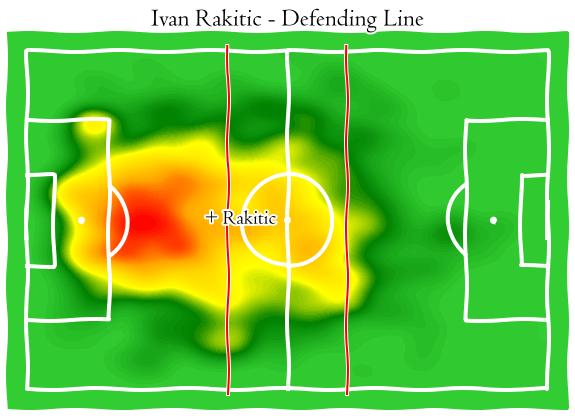

  0%|          | 0/68400 [00:00<?, ?it/s]

Calculando posiciónes del jugadore en el terreno de juego ...

Creando Mapa de calor ...

de Jong : Midfield Line --> (-11.12,6.44)

Guardando imagen ...



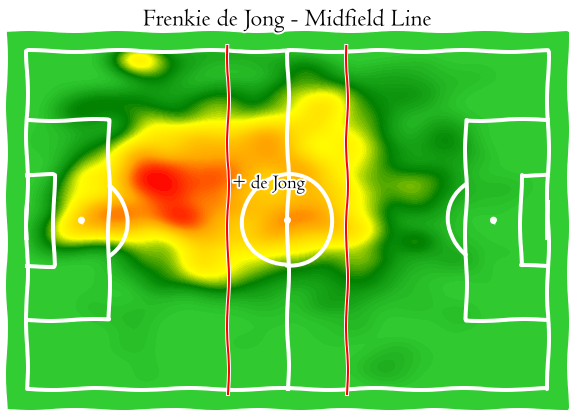

  0%|          | 0/68400 [00:00<?, ?it/s]

Calculando posiciónes del jugadore en el terreno de juego ...

Creando Mapa de calor ...

Roberto : Midfield Line --> (-10.3,-13.08)

Guardando imagen ...



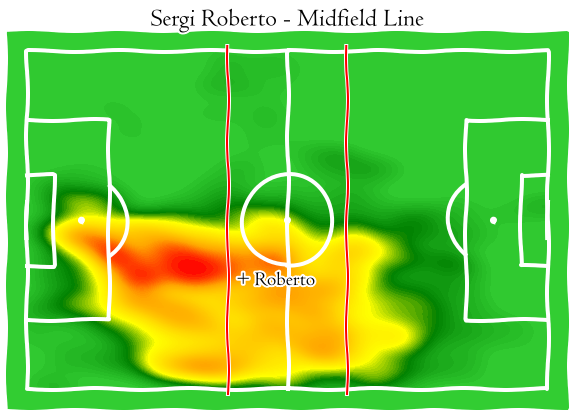

  0%|          | 0/68400 [00:00<?, ?it/s]

Calculando posiciónes del jugadore en el terreno de juego ...

Creando Mapa de calor ...

Griezmann : Midfield Line --> (2.93,10.59)

Guardando imagen ...



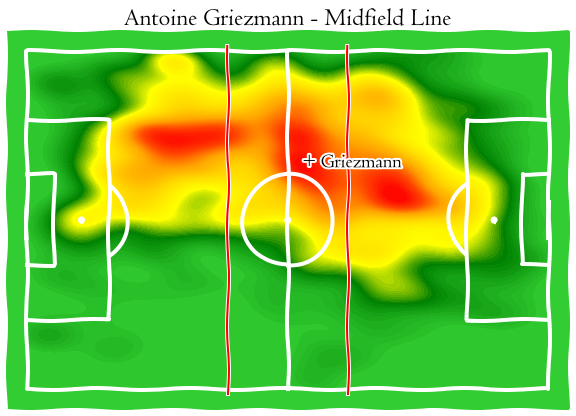

  0%|          | 0/68400 [00:00<?, ?it/s]

Calculando posiciónes del jugadore en el terreno de juego ...

Creando Mapa de calor ...

Messi : Midfield Line --> (5.55,-10.24)

Guardando imagen ...



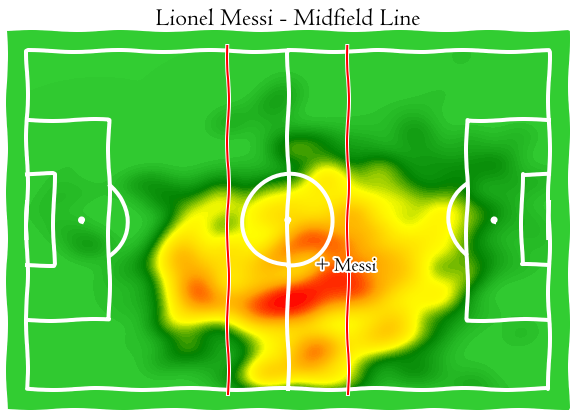

  0%|          | 0/68400 [00:00<?, ?it/s]

Calculando posiciónes del jugadore en el terreno de juego ...

Creando Mapa de calor ...

Suarez : Attacking Line --> (13.88,2.1)

Guardando imagen ...



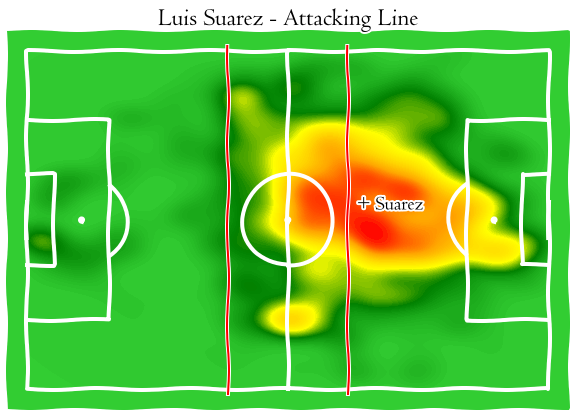

In [34]:
for p in start_p_h:
    pl = generate_player_match_data('data/structured_data.json','data/match_data.json', p)
    plot_player_heatmap(pl)

#### Análisis de jugadores que entraron de recambio en el equipo local

  0%|          | 0/68400 [00:00<?, ?it/s]

Calculando posiciónes del jugadore en el terreno de juego ...

Creando Mapa de calor ...

Vidal : Midfield Line --> (-3.92,-7.18)

Guardando imagen ...



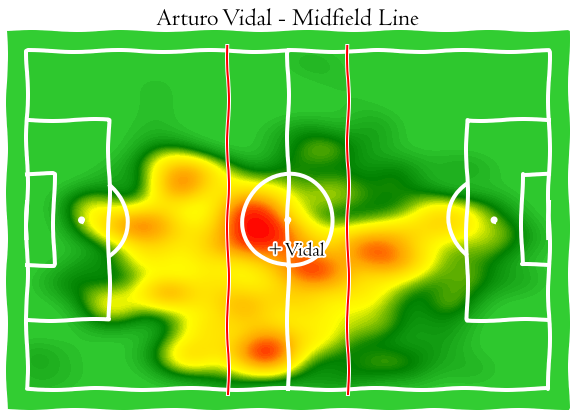

  0%|          | 0/68400 [00:00<?, ?it/s]

Calculando posiciónes del jugadore en el terreno de juego ...

Creando Mapa de calor ...

Fati : Midfield Line --> (2.23,17.72)

Guardando imagen ...



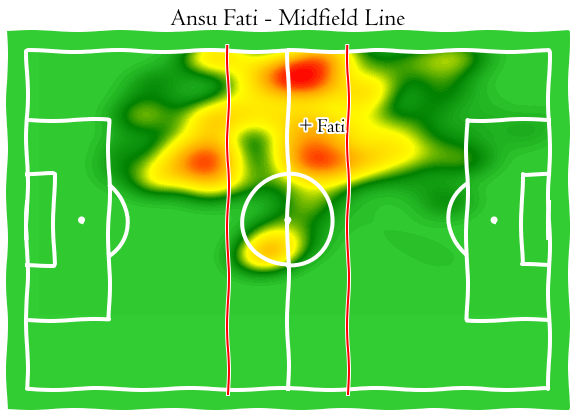

In [35]:
for p in subs_h:
    pl = generate_player_match_data('data/structured_data.json','data/match_data.json', p)
    plot_player_heatmap(pl)

#### Análisis del equipo titular visitante

  0%|          | 0/68400 [00:00<?, ?it/s]

Calculando posiciónes del jugadore en el terreno de juego ...

Creando Mapa de calor ...

Courtois : Defending Line --> (48.36,-0.37)

Guardando imagen ...



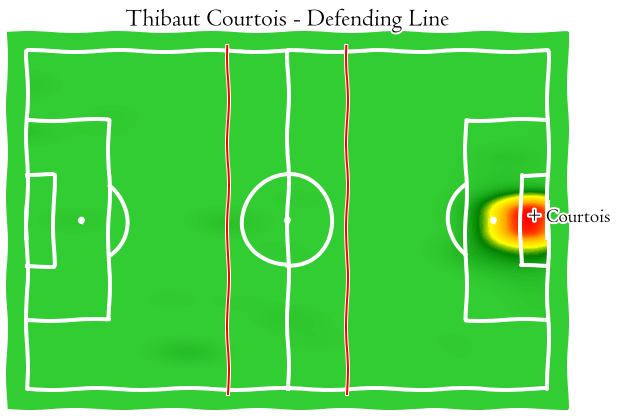

  0%|          | 0/68400 [00:00<?, ?it/s]

Calculando posiciónes del jugadore en el terreno de juego ...

Creando Mapa de calor ...

Ramos : Defending Line --> (14.9,-7.64)

Guardando imagen ...



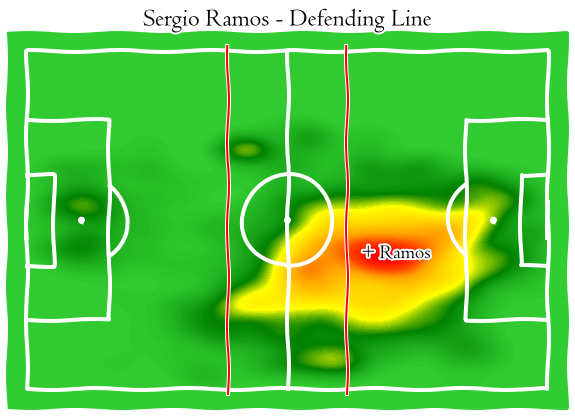

  0%|          | 0/68400 [00:00<?, ?it/s]

Calculando posiciónes del jugadore en el terreno de juego ...

Creando Mapa de calor ...

Varane : Defending Line --> (17.52,4.12)

Guardando imagen ...



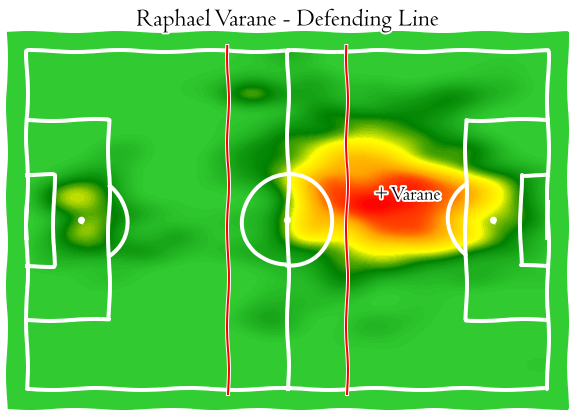

  0%|          | 0/68400 [00:00<?, ?it/s]

Calculando posiciónes del jugadore en el terreno de juego ...

Creando Mapa de calor ...

Mendy : Midfield Line --> (5.71,-20.72)

Guardando imagen ...



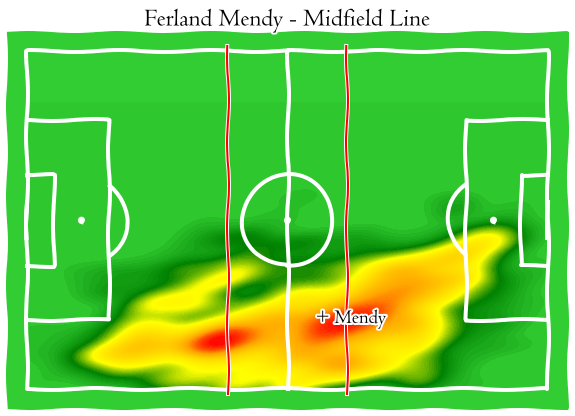

  0%|          | 0/68400 [00:00<?, ?it/s]

Calculando posiciónes del jugadore en el terreno de juego ...

Creando Mapa de calor ...

Carvajal : Midfield Line --> (6.25,17.02)

Guardando imagen ...



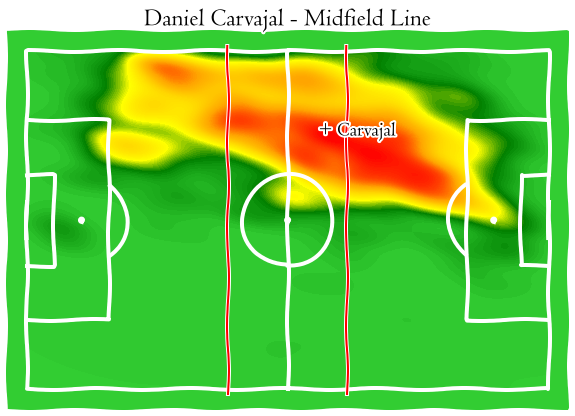

  0%|          | 0/68400 [00:00<?, ?it/s]

Calculando posiciónes del jugadore en el terreno de juego ...

Creando Mapa de calor ...

Casemiro : Midfield Line --> (6.03,0.81)

Guardando imagen ...



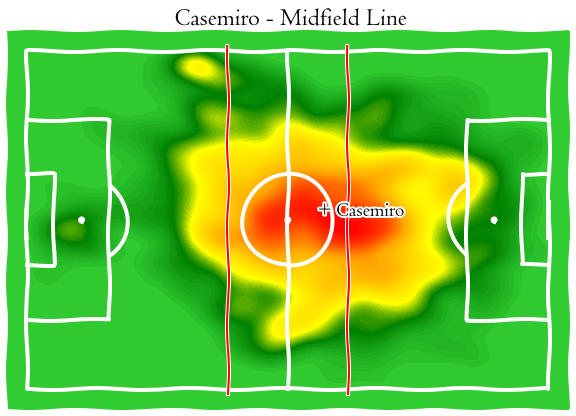

  0%|          | 0/68400 [00:00<?, ?it/s]

Calculando posiciónes del jugadore en el terreno de juego ...

Creando Mapa de calor ...

Kroos : Midfield Line --> (-4.6,-7.75)

Guardando imagen ...



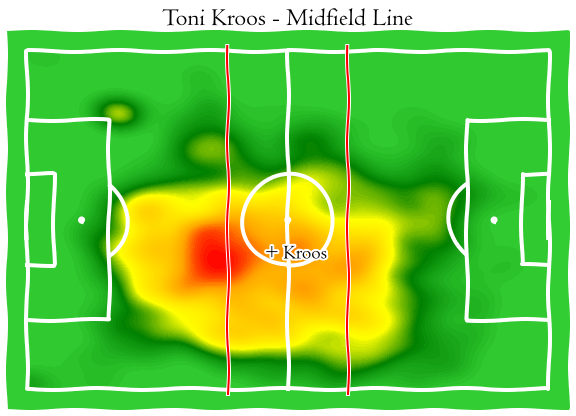

  0%|          | 0/68400 [00:00<?, ?it/s]

Calculando posiciónes del jugadore en el terreno de juego ...

Creando Mapa de calor ...

Valverde : Midfield Line --> (-10.19,8.4)

Guardando imagen ...



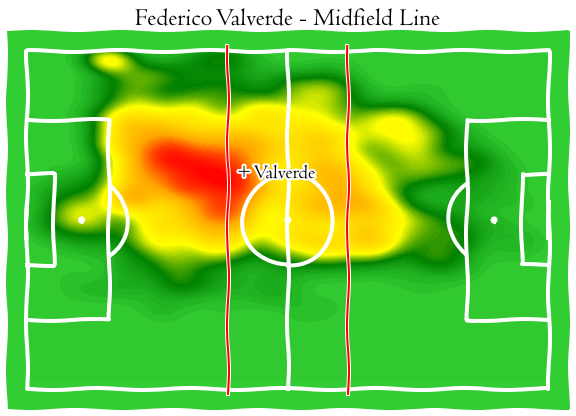

  0%|          | 0/68400 [00:00<?, ?it/s]

Calculando posiciónes del jugadore en el terreno de juego ...

Creando Mapa de calor ...

Isco : Attacking Line --> (-15.2,-7.78)

Guardando imagen ...



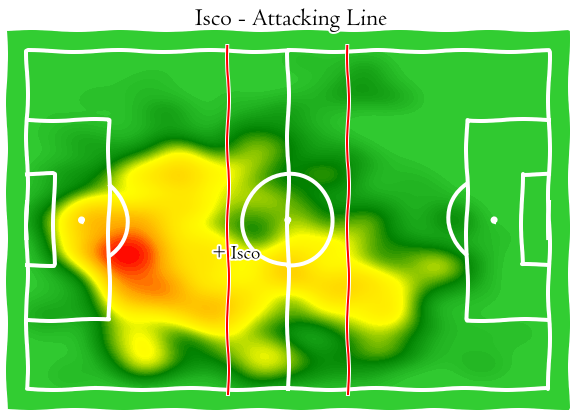

  0%|          | 0/68400 [00:00<?, ?it/s]

Calculando posiciónes del jugadore en el terreno de juego ...

Creando Mapa de calor ...

Bale : Attacking Line --> (-12.75,15.9)

Guardando imagen ...



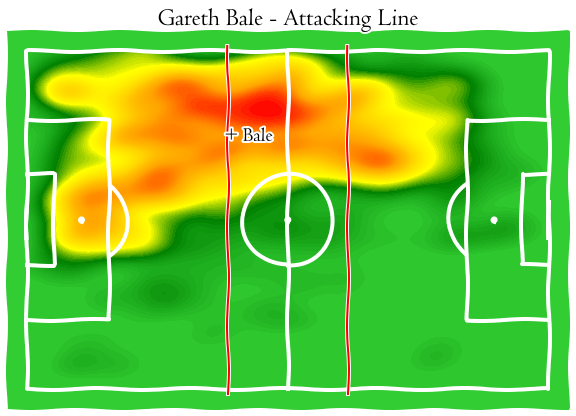

  0%|          | 0/68400 [00:00<?, ?it/s]

Calculando posiciónes del jugadore en el terreno de juego ...

Creando Mapa de calor ...

Benzema : Attacking Line --> (-20.82,-3.86)

Guardando imagen ...



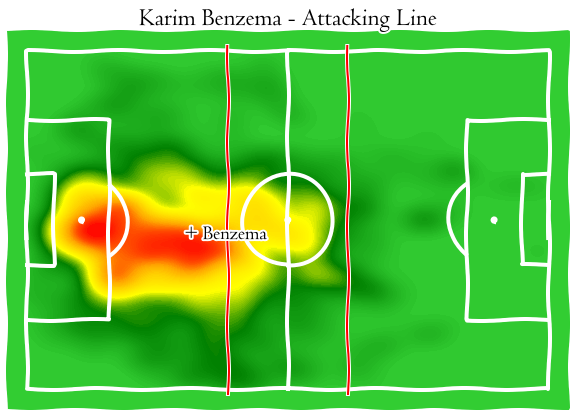

In [36]:
for p in start_p_a:
    pl = generate_player_match_data('data/structured_data.json','data/match_data.json', p)
    plot_player_heatmap(pl)

#### Análisis de jugadores que entraron de recambio en el equipo visitante

  0%|          | 0/68400 [00:00<?, ?it/s]

Calculando posiciónes del jugadore en el terreno de juego ...

Creando Mapa de calor ...

Modric : Midfield Line --> (-3.42,8.84)

Guardando imagen ...



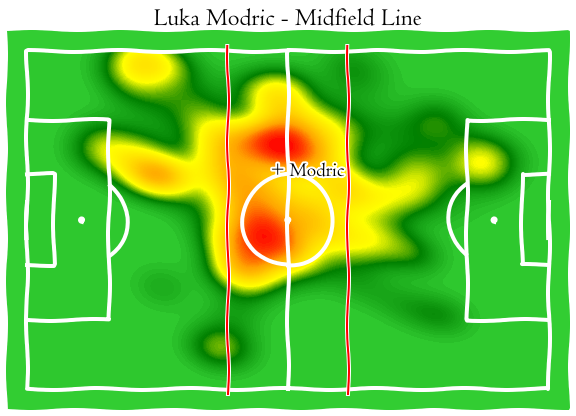

  0%|          | 0/68400 [00:00<?, ?it/s]

Calculando posiciónes del jugadore en el terreno de juego ...

Creando Mapa de calor ...

Rodrygo : Midfield Line --> (-10.29,-20.65)

Guardando imagen ...



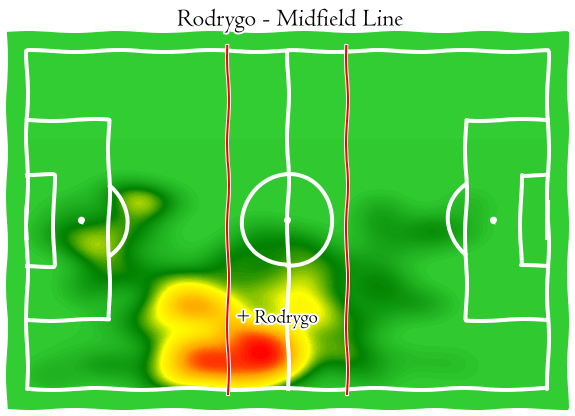

In [37]:
for p in subs_a:
    pl = generate_player_match_data('data/structured_data.json','data/match_data.json', p)
    plot_player_heatmap(pl)